## TODO
Hypothesis


Stuff up here

# COGS108 Final Project

## Group Members
* ** PUT YOUR NAMES HERE **

## Dataset

#### Data 1
* Dataset Name: College Scorecard
* Link to the dataset: https://collegescorecard.ed.gov/data/
* Number of observations: 6000
This dataset contains information that College Scorecard thinks are important in comparing the cost and value of higher education institutions in the United States.


#### Data 2
* Dataset Name: Highest Paying Bachelor Degrees by Salary Potential
* Link to the dataset: https://www.payscale.com/college-salary-report/majors-that-pay-you-back/bachelors?page=33
* Number of observation: 600
This dataset ranks the salary potential of varying major degrees.


## Data Cleaning

### Data 1: College Scorecard
The data we will be using is provided by College Scorecard which is an online tool, created by the United States government, for consumers to compare the cost and value of higher education institutions. This data contains statistics throughout the years on factors that can lead to .. // tbd

What we are mainly interested is to find whether there is an increase in STEM majors proportions throughout this decade. From this dataset, there is statistics on the distribution of majors for each college and universities. We can see the percentage each major takes up for each college and university.


We have this data for years from 1996 to 2015.

To make things easier, we take 5 samples from these years and see whether or not we can find a trend of increasing STEM majors.
We will look at the percentages in the past 10 years and see if we can find anything important



First we will gather the files we need. We have data from 1996 to 2015. We will look at 5 samples from the past 10 years. Namely, 2015, 2011, 2007, 2003, 1999.



In [43]:
# Import modules 
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind
from numpy.random import rand
from mpl_toolkits.mplot3d import Axes3D

In [44]:
DATA_1999_F = "data/MERGED1999_00_PP.csv"
DATA_2003_F = "data/MERGED2003_04_PP.csv"
DATA_2007_F = "data/MERGED2007_08_PP.csv"
DATA_2011_F = "data/MERGED2011_12_PP.csv"
DATA_2015_F = "data/MERGED2015_16_PP.csv"


Each file contains the statistics for that specific year and each row in the dataset is a college/university. Columns contain the statistics for the college. The columns name are codes so it will not take up too much space.
The data has a dictionary connects the keys to the column name.

Below we want to create a python dictionary that when given the column code from out dataset, it will return the column name.

In [45]:
DICT_F = "data/CollegeScorecardDataDictionary.xlsx"

xls = pd.ExcelFile(DICT_F)
df = pd.read_excel(xls, sheet_name='data_dictionary')

print (df)
# Drop all rows that do not have the KEY_PHRASE
KEY_PHRASE = "Percentage of degrees awarded"
df = df[df['dev-category'] == 'academics']
df = df[df['NAME OF DATA ELEMENT'].str.contains(KEY_PHRASE)]

# Drop columns that we do not care about
columns_to_keep = ['NAME OF DATA ELEMENT', 'VARIABLE NAME']
df_dict = df[columns_to_keep]

# df_dict now contains ['Name of data', 'Variable name']

                                   NAME OF DATA ELEMENT dev-category  \
0                               Unit ID for institution         root   
1                        8-digit OPE ID for institution         root   
2                        6-digit OPE ID for institution         root   
3                                      Institution name       school   
4                                                  City       school   
5                                        State postcode       school   
6                                              ZIP code       school   
7                            Accreditor for institution       school   
8                        URL for institution's homepage       school   
9            URL for institution's net price calculator       school   
10       Predominant degree awarded (recoded 0s and 4s)       school   
11    Schools that are on Heightened Cash Monitoring...       school   
12                                 Flag for main campus       sc

In [46]:
# Create a dictionary that has variable name as key, and major name as value
var_ls  = df_dict['VARIABLE NAME']
name_ls = df_dict['NAME OF DATA ELEMENT']

col_dict = dict()
for var, name in zip(var_ls, name_ls):
    name = name.replace("Percentage of degrees awarded in ", "")
    name = name.rstrip('.')
    col_dict[var] = name
    

Now that we have the dictionary created, we can start cleaning the real dataset.
The dataset is huge but all we care about is only the major distribution percentages for each college. Therefore, we can extract just the major distribution columns for each college and drop the rest.

We go through each year's data and filter out only the "Percentage of degrees awarded" columns.
After filter we filter out the columns, we noticed that some rows have values all 0 or NaN, which probably means that the dataset did not get their information from that college for that specfic year. Since we only want to see the trends of major percentage changes, we only care about the average trend for each year. As a result, we choose to just drop those college that did not provide data from our dataset.

We will have to load and clean the data for each data set, thus we write a function that loads the data and cleans it for us to make things easier.

In [47]:
def load_and_clean_data (filename):
    """Cleans csv data, get major stats, drop 0 data.
       Return: Pandas df where row    == colleges
                               column == majors
    """
    # Load data from csv into pandas
    df = pd.read_csv(filename, dtype=str)
    
    # Get college names
    inst_names = df['INSTNM']

    # Extract only columns on major statistics
    df = df.filter(like='PCIP')

    # Drop rows that have NaN or all 0 values
    df = df.dropna()
    df = df.loc[(df!=0).any(axis=1)]
    
    # Append college name to df
    df = pd.concat([inst_names, df], axis=1)
    return df

In [80]:
# Load all data to DF
df_1999 = load_and_clean_data(DATA_1999_F)
# TODO
"""uncomment these lines below to load dataset for 2003, 2007, 2011, 2015"""
df_2003 = load_and_clean_data(DATA_2003_F)
df_2007 = load_and_clean_data(DATA_2007_F)
df_2011 = load_and_clean_data(DATA_2011_F)
df_2015 = load_and_clean_data(DATA_2015_F)

df_1999 # print df_1999 for reference

,INSTNM,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,...,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54
0,Alabama A & M University,0.0595,0.0099,0.0119,0,0,0.0337,0.0476,0,0.2044,...,0.0298,0.0397,0,0,0,0,0.006,0,0.2421,0.002
1,University of Alabama at Birmingham,0,0,0,0,0.0242,0,0.019,0,0.1414,...,0.017,0.0543,0,0,0,0,0.019,0.1649,0.1957,0.0386
2,Amridge University,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,University of Alabama in Huntsville,0,0,0,0.0015,0,0,0.0386,0,0.0104,...,0,0.0148,0,0,0,0,0.0193,0.2552,0.1929,0.0089
4,Alabama State University,0,0,0,0,0.0506,0,0.1118,0,0.3143,...,0.0338,0.0316,0,0,0,0,0.0063,0,0.1392,0.0063
5,The University of Alabama,0,0.004,0.0007,0.0026,0.0948,0,0.0058,0,0.093,...,0.0117,0.0405,0,0,0,0,0.0412,0.0744,0.2836,0.023
6,Central Alabama Community College,0,0,0,0,0,0,0.0441,0.0441,0,...,0,0,0,0.0373,0.0441,0,0,0.3051,0.0746,0
7,Athens State University,0,0,0,0,0,0,0.0597,0,0.3208,...,0,0.0129,0,0,0,0,0.007,0.0129,0.356,0.0023
8,Auburn University at Montgomery,0,0,0,0,0.0442,0,0,0,0.2151,...,0,0.0442,0,0,0,0,0.0399,0.067,0.2821,0.0128
9,Auburn University,0.0528,0.025,0.0224,0,0.037,0,0.0013,0,0.1255,...,0.0097,0.038,0,0,0,0,0.0255,0.0729,0.2265,0.0138


Now that we have a list of college with its major distribution percentages, it nice if we have a way to categories the STEM majors so it will be easier to see the trend.

In [49]:
# TODO categorize STEM major
""" if someone needs this ask me (Jeff) I can do it"""

' if someone needs this ask me (Jeff) I can do it'

In [50]:
# Checks that all 5 datasets are correctly loaded
assert isinstance(df_1999, pd.DataFrame)
# assert isinstance(df_2003, pd.DataFrame)
# assert isinstance(df_2007, pd.DataFrame)
# assert isinstance(df_2011, pd.DataFrame)
# assert isinstance(df_2015, pd.DataFrame)


### README ###
How to use the dataset: 
1. just print the df and you can see the format.
2. column names have names 'PCIP' + number. (which is a bit confusing)
3. To make things easier, I created a python dictionary called 'col_dic' that takes input the column names and outputs the major name
   
   Ex: col_dict['PCIP01'] returns the string "Agriculture, Agriculture Operations, And Related Sciences"
   
   (You can print col_dict to see its contents)


## Data 2: Salary payout by Major

This dataset is listed on a website that shows a ranking of potential salary payout based on major.

We will use webscraping to retrieve this information.

For webscraping we require request and BeautifulSoup

In [51]:
import requests
import bs4
from bs4 import BeautifulSoup

In [52]:
DATA2_URL = 'https://www.payscale.com/college-salary-report/majors-that-pay-you-back/bachelors?page=33'
page = requests.get(DATA2_URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [53]:
import re
p = re.compile('var collegeSalaryReportData = (.*);')   

for script in soup.find_all("script", {"src":False}):
    if script:
        m = p.search(str(script.string))
        if (m):
            data = m
            break
        
# pd.read_json(data.group(1))
df2 = pd.read_json(data.group(1))
df2.drop(columns=['Url'], inplace=True)
df2

,% High Job Meaning,0-5 Years Experience,10-20 Years Experience,20+ Years Experience,5-10 Years Experience,Degree Type,Early Career Median Pay,Major,Mid-Career Median Pay,Rank,Tie
0,0.65,94600,152800,199200,135800,Bachelor's,94600,Petroleum Engineering,175500,1,NaN
1,0.49,56400,133300,N/A,86100,Bachelor's,56400,Actuarial Mathematics,131700,2,NaN
2,0.43,61200,129500,138500,95800,Bachelor's,61200,Actuarial Science,130800,3,NaN
3,0.72,69000,117000,132900,92400,Bachelor's,69000,Nuclear Engineering,127500,4,NaN
4,0.57,70300,113600,139500,90900,Bachelor's,70300,Chemical Engineering,124500,5,NaN
5,0.68,73900,110100,144700,85900,Bachelor's,73900,Marine Engineering,123200,6,NaN
6,0.36,60000,114700,N/A,90400,Bachelor's,60000,Economics and Mathematics,122900,7,NaN
7,N/A,54100,99900,N/A,N/A,Bachelor's,54100,Geophysics,122200,8,NaN
8,0.4,54000,117700,N/A,89800,Bachelor's,54000,Cognitive Science,121900,9,NaN
9,0.7,68600,N/A,127900,94500,Bachelor's,68600,Electrical Power Engineering,119100,10,NaN


## Data Visualization

### Data 2: Salary payout by Major

Text(0.5,1,'Top 500 Majors distribution of Early Career Median Pay')

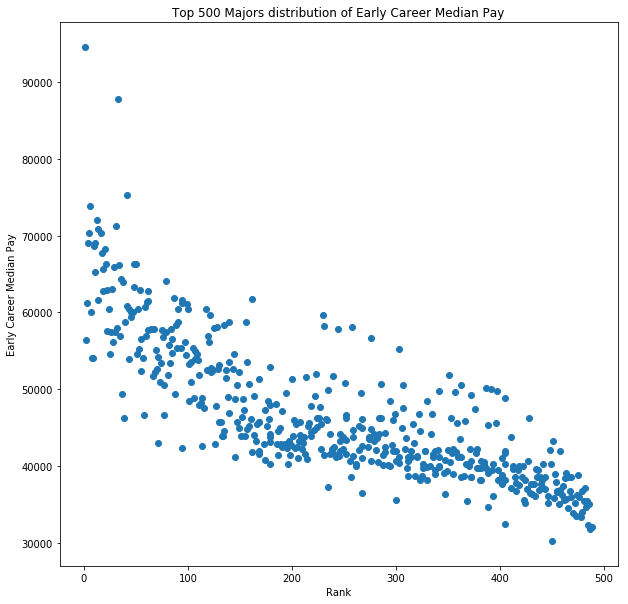

In [59]:
all_compound_df = df2[['Rank', 'Early Career Median Pay']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['Early Career Median Pay'])
plt.ylabel('Early Career Median Pay')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of Early Career Median Pay')

Text(0.5,1,'Top 500 Majors distribution of Mid-Career Median Pay')

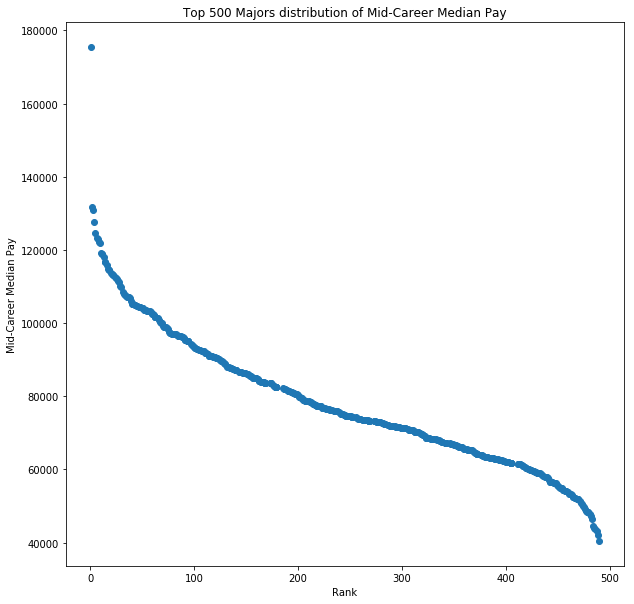

In [60]:
all_compound_df = df2[['Rank', 'Mid-Career Median Pay']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['Mid-Career Median Pay'])
plt.ylabel('Mid-Career Median Pay')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of Mid-Career Median Pay')

Text(0.5,1,'Top 500 Majors distribution of 0-5 Years Experience Pay')

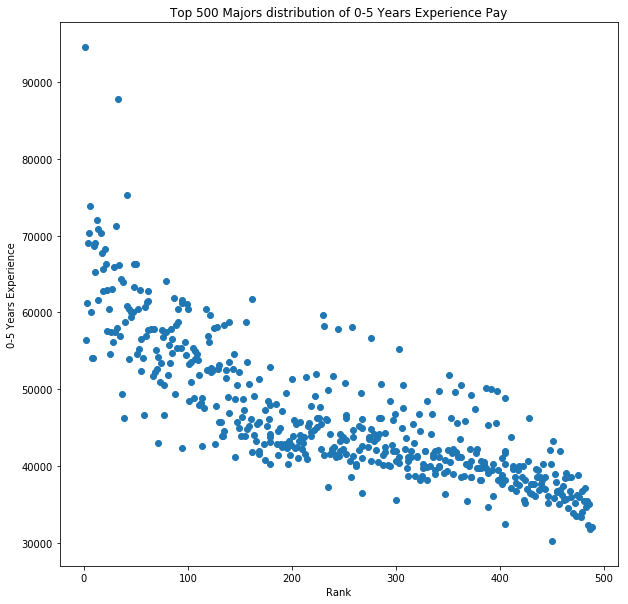

In [62]:
all_compound_df = df2[['Rank', '0-5 Years Experience']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['0-5 Years Experience'])
plt.ylabel('0-5 Years Experience')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of 0-5 Years Experience Pay')